In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import skimage.io
import cv2 as cv
import math

from skimage.io import imshow
from math import pi
from numpy import sqrt

import scipy.ndimage as ndi
import skimage.draw as draw
from skimage.util import invert
from skimage.feature import canny, peak_local_max
from skimage.filters import rank, sobel, threshold_otsu, threshold_local, threshold_minimum, gaussian
from skimage.morphology import disk, erosion, dilation, watershed, remove_small_holes, remove_small_objects, convex_hull_object, area_opening
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.exposure import adjust_gamma, rescale_intensity, equalize_hist

In [3]:
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
CYAN = (0, 255, 255)
MAGENTA = (255, 0, 255)
YELLOW = (255, 255, 0)

In [4]:
def imshow_bgr(x, **kwargs):
    imshow(cv.cvtColor(x, cv.COLOR_BGR2RGB), **kwargs)
    
def imshow_grid(xs, rows, cols, **kwargs):
    plt.figure(figsize=(10, 10), dpi=100)
    for i, x in enumerate(xs):
        plt.subplot(rows, cols, i+1)
        imshow(x, **kwargs)
    plt.show()

def cvimshow(x, title="opencv"):
    cv.imshow(title, x)

def ski2cv(x):
    return (x * 255).astype(np.uint8)

def norm(x):
    return (x - x.min()) / (x.max() - x.min())

def dist(a, b):
    (ax, ay), (bx, by) = a, b
    return np.sqrt((ax - bx)**2 + (ay - by)**2)

def is_gray(x):
    return len(x.shape) == 2 or x.shape[2] == 1

def shrink(x, side=400):
    w1, h1, _ = x.shape
    w2, h2 = side, side
    if w1 < h1:
        h2 = w2 * w1 // h1
    else:
        w2 = h2 * h1 // w1
    x = cv.resize(x, (w2, h2))
    return x

def to_gray(x):
    return cv.cvtColor(x, cv.COLOR_BGR2GRAY)
    
class cvwindow:
    def __init__(self, img, title="opencv"):
        cv.namedWindow(title, cv.WINDOW_AUTOSIZE)
        self.out = img
    def __enter__(self):
        return self.out
    def __exit__(self, type, value, traceback):
        cv.waitKey(0)
        cv.destroyAllWindows()

In [5]:
def bump_contrast(x):
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab = cv.cvtColor(x, cv.COLOR_BGR2LAB)
    l, a, b = cv.split(lab)
    l = clahe.apply(l)
    lab = cv.merge((l, a, b))
    bgr = cv.cvtColor(lab, cv.COLOR_LAB2BGR)
    return bgr

def preprocess(x):
    #x = cv.medianBlur(x, 3)
    return x

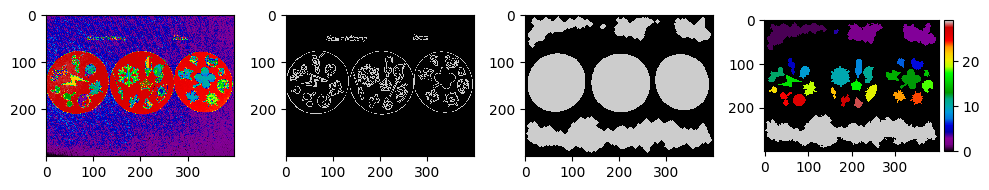

In [14]:
def elevation(x):
    assert(is_gray(x))
    x = ski2cv(rescale_intensity(x))
    x = cv.GaussianBlur(x, (3, 3), 2, 2)
    return sobel(x)

def canny_rgb(x):
    res = np.zeros_like(x)
    for i in range(3):
        col = x[:,:,i]
        col = rescale_intensity(col)
        res[:,:,i] = canny(col, sigma=1, low_threshold=0, high_threshold=170)
    return res

def circle_mask(x):
    assert(is_gray(x))
    x = x > threshold_local(x, 51)
    x = ndi.binary_fill_holes(x)
    for _ in range(10): x = erosion(x)
    for _ in range(5): x = dilation(x)
    #x = remove_small_objects(x, 2000, connectivity=2)
    return x

def get_dobbles(x):
    assert(is_gray(x))
    mask = circle_mask(x)
    x = x > threshold_local(x, 71)
    x = invert(x) * mask
    for _ in range(1): x = dilation(x)
    for _ in range(1): x = erosion(x)
    x = ndi.binary_fill_holes(x)
    x = remove_small_objects(x)
    x, _ = ndi.label(x)
    #x = convex_hull_object(x)
    return x

def do_dobble(path):
    src = cv.imread(path)
    img = shrink(src)
    gray = to_gray(img)
    wtf = canny_rgb(img).sum(axis=2) > 0

    dobbles = get_dobbles(gray)
    circles = circle_mask(gray)
    dobble_cs, dobble_hs = cv.findContours(ski2cv(dobbles), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    circle_cs, circle_hs = cv.findContours(ski2cv(circles), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    imgs = [gray, wtf, circles, dobbles]
    imshow_grid(imgs, 1, 4, cmap='nipy_spectral')
    return img, dobble_cs, dobble_hs, circle_cs, circle_hs

src, dobble_cs, dobble_hs, circle_cs, circle_hs = do_dobble('res/medium/2.png')

In [16]:
hier = {}
radius = {}
pics = {}

with cvwindow(src) as out:
    for i, c in enumerate(circle_cs):
        # not an ellipse
        if len(c) < 5: continue
        M = cv.moments(c)
        A = M['m00']
        if A == 0: continue
        r = sqrt(A / pi)
        P = cv.arcLength(c, True)
        roundness = 4*pi*A / P**2
        d = (M['m20'] - M['m02'])**2
        eccentric = (d - 4*M['m11']**2) / d
        # not circly enough or too small
        if roundness < 0.6 or r < 30: continue
        approx = cv.approxPolyDP(c, 0.01*P, True)
        #if len(approx) < 8: continue
        x = int(M['m10'] / M['m00'])
        y = int(M['m01'] / M['m00'])
        ellipse = cv.fitEllipse(c)
        ax1, ax2 = ellipse[1]
        # too squishy
        if abs(ax1 / ax2) < 0.7: continue
        # todo: better check if object is inside ellipse
        hier[(x, y)] = []
        radius[(x, y)] = r
        cv.ellipse(out, ellipse, RED, 1)
        
    for i, c in enumerate(dobble_cs):
        M = cv.moments(c)
        A = M['m00']
        if A == 0: continue
        r = sqrt(A / pi)
        # too small
        #if r < 10: continue
        x = int(M['m10'] / M['m00'])
        y = int(M['m01'] / M['m00'])
        # closest circle
        nearest = sorted(hier.keys(), key=lambda center: dist((x, y), center))
        # no circles on image
        if not nearest: continue
        cx, cy = nearest[0]
        # not inside a circle
        if dist((x, y), (cx, cy)) > radius[(cx, cy)]: continue
        
        if (cx, cy) not in pics: pics[(cx, cy)] = []
        pics[(cx, cy)] += []
            
        cv.line(out, (x, y), (cx, cy), WHITE, 1)
        cv.drawContours(out, dobble_cs, i, GREEN, 1)
        cv.rectangle(out, (x, y), (x+2, y+2), WHITE, 2)
        
    cvimshow(out)